In [1]:
source("qa_plot_functions.R")
library(reshape2)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths



## Additional plotting functions

In [29]:
library(grid)
library(gridExtra)
library(repr)
library(Hmisc)
options(repr.plot.width=7, repr.plot.height=3)


qc_qa_plots<-function(df,label_strings){
    
    grid.newpage()
    ncol=7
    nrow=1
    pushViewport(viewport(layout = grid.layout(nrow, ncol)))
    
    mean_sdlow<-function(x) (mean(x)-sd(x))
        
    mean_sdhigh<-function(x) (mean(x)+sd(x))
    
    vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

    pval_thresh=c(0.05,0.01,0.001,0.0001)
    pval_indicators=c("*","**","***","****")

    for (i in seq(1,length(measure.vars)))
    {
        # get only the rows corresponding to this measure
        sdf<- df %>% filter(Measure == measure.vars[i])
        sdf_ranges <- sdf %>% 
                       group_by(qc_anat) %>% 
                         summarise(y=mean(value),y.max=mean_sdhigh(value),y.min=mean_sdlow(value)) %>% 
                             ungroup

        # get the lable and annotate to indicate statistical significance of the difference
        pval<-wilcox.test(value~as.factor(qc_anat),data=sdf)$p.value

        pval_string="ns"
        for (t in seq(1,length(pval_thresh)))
        {
            if(pval < pval_thresh[t])
            {
                pval_string=pval_indicators[t]
            }
        }

        print(paste(label_strings[i],pval_string,sprintf('pval %e',pval)))

        p <- ggplot(sdf, aes(x=as.factor(qc_anat), y=value, fill=as.factor(qc_anat))) + 
            geom_boxplot(outlier.shape = NA, width=.5, fill='white') + 
            geom_point(data=sdf_ranges,aes(x=qc_anat,y=y),color="red",fill="red",size=1)+
            geom_point(data=sdf_ranges,aes(x=qc_anat,y=y.max),shape=24,color="red",fill="red",size=1)+
            geom_point(data=sdf_ranges,aes(x=qc_anat,y=y.min),shape=25,color="red",fill="red",size=1)+
            theme_bw() +
            ggtitle(pval_string)+
            xlab("")+
            ylab(label_strings[i])+
            theme(legend.position = "none",
                  plot.title = element_text(family = "ArialMT",
                                             face = "plain",
                                             size = 10,
                                             vjust = 0,
                                             hjust = 0.5),
                  axis.text.x = element_text(family = "ArialMT",
                                             face = "plain",
                                             size = 8, 
                                             angle = 0, 
                                             hjust = 0.5),
                  axis.text.y = element_text(family = "ArialMT", 
                                             face = "plain", 
                                             size = 8, 
                                             angle = 90, 
                                             hjust = 0.5),
                  axis.title.y = element_text(family = "ArialMT", 
                                              face = "plain", 
                                              size = 10, 
                                              angle = 90, 
                                              vjust = 0.9),
                  plot.margin = unit(c(.25, .25, 0.25, .25), 
                                     "lines")) +

            # reduce the range to between the 2% and 98% quartiles to make the plot
            # range more readible, do this without censoring so that the bars will go
            # out of frame
            coord_cartesian(ylim=with(sdf, quantile(value, probs = c(0.02,.98))))


        # get the location of this plot in the grid
        x=ceiling(i/ncol)
        y=((i-1) %% ncol)+1

        # add the plot to the grid
        print(p, vp = vplayout(x, y))
    }
}

# Read in and tidy the manual QC ratings

## Lets get the pheno file directly from the Internets!

In [30]:
pheno_df<-read.csv("http://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE/Phenotypic_V1_0b_preprocessed1.csv")

### Conform the names of the raters and their ratings


In [31]:
#conform the names of the raters and their ratings
rater_cols <- setdiff(grep("*rater_", names(pheno_df)),grep("*notes_rater", names(pheno_df)))

# reduce to the columns of interest
pheno_df=pheno_df[c("SUB_ID","SITE_ID",names(pheno_df)[rater_cols],"SUB_IN_SMP")]

# rename SUB_IN_SMP to rater #4
names(pheno_df)[1]="Participant"
names(pheno_df)[8]="qc_rater_4"

# lets be really conservative and make all "maybe" fail
pheno_df[pheno_df=="maybe"]<-"fail"

# rater 4 used 0s and 1s instead of OK and fail, rename them
pheno_df$qc_rater_4=factor(pheno_df$qc_rater_4,levels=c(0,1),labels=c("fail","OK"))

# lets code all missing values as NA, so that they can be easily ignored in future processing
pheno_df[pheno_df==""]<-NA

head(pheno_df)

Participant,SITE_ID,qc_rater_1,qc_anat_rater_2,qc_func_rater_2,qc_anat_rater_3,qc_func_rater_3,qc_rater_4
50002,PITT,fail,OK,fail,OK,fail,OK
50003,PITT,OK,OK,OK,OK,OK,OK
50004,PITT,OK,OK,OK,OK,OK,OK
50005,PITT,OK,OK,fail,OK,OK,fail
50006,PITT,OK,OK,fail,OK,OK,OK
50007,PITT,OK,OK,fail,OK,OK,OK


### Calculate consensus ratings for the anatomical data

In [32]:
pheno_df$qc_anat<-apply(pheno_df[,c(3,4,6,8)],1, function(x) sum(x=="OK", na.rm=T))
pheno_df$qc_anat<-(pheno_df$qc_anat > 2) + 1
pheno_df$qc_anat<-factor(pheno_df$qc_anat, levels=c(1,2), labels=c("Fail", "OK"))

### Calculate consensus ratings for the functional data

In [33]:
pheno_df$qc_func<-apply(pheno_df[,c(3,5,7,8)],1, function(x) sum(x=="OK", na.rm=T))
pheno_df$qc_func<-(pheno_df$qc_func > 2) + 1
pheno_df$qc_func<-factor(pheno_df$qc_func, levels=c(1,2), labels=c("Fail", "OK"))

# ABIDE Anatomical QAP measures

### Read in the QAP measures, reduce to only the columns of interest, format for later processing, and plot

Participant,Site,Session,Series,qc_anat,Measure,value
50002,Pitt,session_1,anat_1,OK,CNR,11.737636
50003,Pitt,session_1,anat_1,OK,CNR,9.307147
50004,Pitt,session_1,anat_1,OK,CNR,12.188784
50005,Pitt,session_1,anat_1,OK,CNR,12.461291
50006,Pitt,session_1,anat_1,OK,CNR,13.148553
50007,Pitt,session_1,anat_1,OK,CNR,9.443249


[1] "CNR **** pval 1.760059e-11"
[1] "Cortical Contrast **** pval 6.351518e-08"
[1] "EFC ** pval 3.229117e-03"
[1] "FBER ns pval 1.069308e-01"
[1] "Smoothness (FWHM) ns pval 2.532919e-01"
[1] "Fraction of Artifact Voxels **** pval 7.913133e-15"
[1] "SNR ** pval 7.035576e-03"


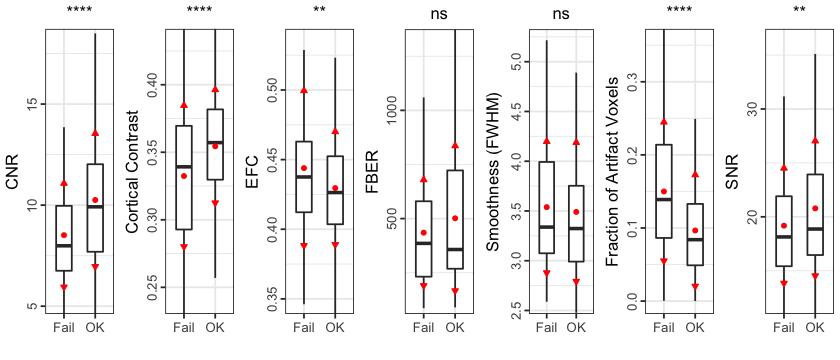

In [51]:
abide_anat_spat_df<-read.csv("2016_05_ABIDE_qap_anatomical_spatial.csv")

abide_anat_spat_df=merge(abide_anat_spat_df, pheno_df[c('Participant','qc_anat')], by='Participant')

id.vars=c('Participant','Site','Session','Series','qc_anat')
measure.vars=c('CNR','Cortical.Contrast','EFC','FBER','FWHM','Qi1','SNR')
abide_anat_spat_df<-abide_anat_spat_df[c(id.vars,measure.vars)]

abide_anat_spat_df=melt(abide_anat_spat_df,
                        id.vars=id.vars,
                        measure.vars=measure.vars,
                        variable.name="Measure")

# remove outliers
abide_anat_spat_df <- abide_anat_spat_df %>% drop_na()
head(abide_anat_spat_df)

# plots
label_strings=c('CNR','Cortical Contrast','EFC','FBER','Smoothness (FWHM)','Fraction of Artifact Voxels','SNR')
qc_qa_plots(abide_anat_spat_df,label_strings)

# ABIDE Functional Spatial QAP measures

### Read in the QAP measures, reduce to only the columns of interest, format for later processing, and plot

Participant,Site,Session,Series,qc_anat,Measure,value
50002,Pitt,session_1,rest_1,OK,EFC,0.6130961
50003,Pitt,session_1,rest_1,OK,EFC,0.5783131
50004,Pitt,session_1,rest_1,OK,EFC,0.5795240
50005,Pitt,session_1,rest_1,OK,EFC,0.5561542
50006,Pitt,session_1,rest_1,OK,EFC,0.5628429
50007,Pitt,session_1,rest_1,OK,EFC,0.6081622


[1] "EFC **** pval 6.969625e-07"
[1] "FBER ns pval 1.076829e-01"
[1] "Smoothness (FWHM) **** pval 3.327857e-05"
[1] "GSR **** pval 3.443936e-13"
[1] "SNR **** pval 8.214009e-05"


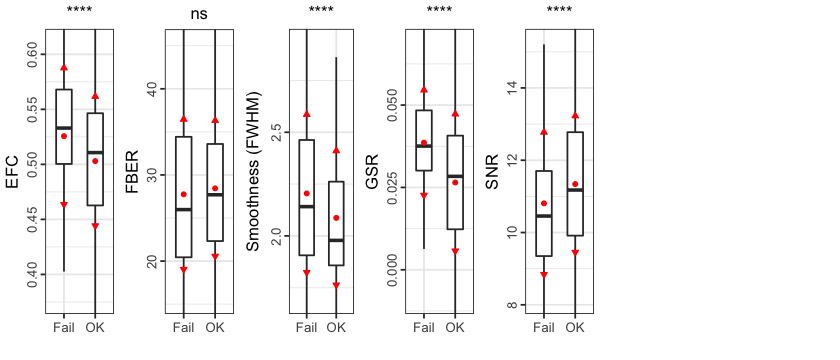

In [52]:
abide_func_spat_df<-read.csv("2016_05_ABIDE_functional_spatial.csv")

abide_func_spat_df=merge(abide_func_spat_df, pheno_df[c('Participant','qc_anat')], by='Participant')
id.vars=c('Participant','Site','Session','Series','qc_anat')
measure.vars=c('EFC','FBER','FWHM','Ghost_y','SNR')
abide_func_spat_df<-abide_func_spat_df[c(id.vars,measure.vars)]

abide_func_spat_df=melt(abide_func_spat_df,
                        id.vars=id.vars,
                        measure.vars=measure.vars,
                        variable.name="Measure")

# remove outliers
abide_func_spat_df <- abide_func_spat_df %>% drop_na()
head(abide_func_spat_df)

# plots
label_strings=c('EFC','FBER','Smoothness (FWHM)','GSR','SNR')
qc_qa_plots(abide_func_spat_df,label_strings)